In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 20

Found 402 files belonging to 4 classes.
Classes: ['A', 'B', 'C', 'D']


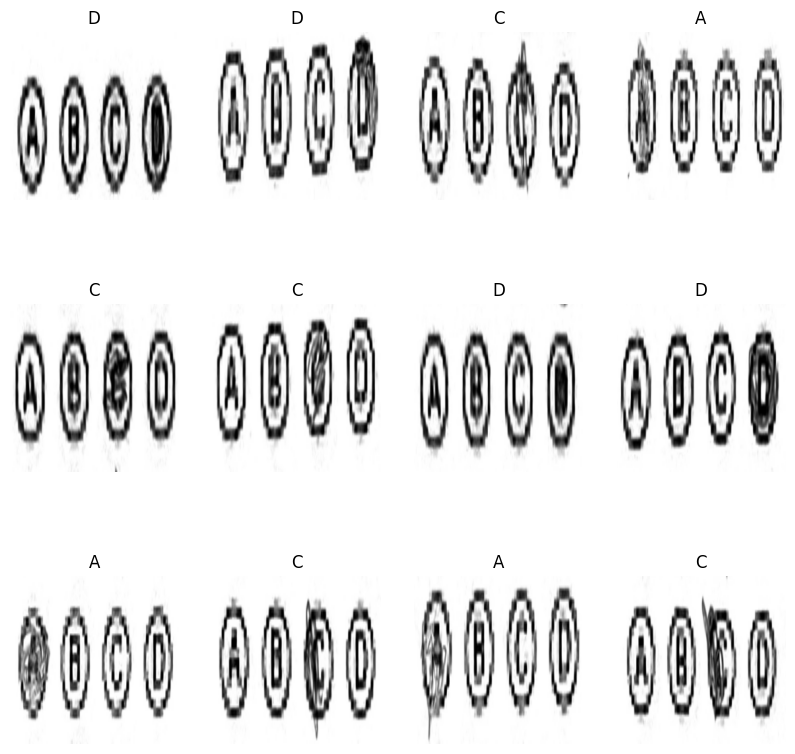

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print(f"Classes: {class_names}")

# Visualize sample images
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [4]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [5]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
resize_and_rescale = tf.keras.Sequential([ 
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), 
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([ 
    layers.RandomFlip("horizontal_and_vertical"), 
    layers.RandomRotation(0.2) 
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [7]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')  # Output layer for multi-class classification
])

model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,743,044 (14.28 MB)

 Trainable params: 3,743,044 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.3050 - loss: 2.9440 - val_accuracy: 0.1562 - val_loss: 1.3903
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.2468 - loss: 1.3897 - val_accuracy: 0.2812 - val_loss: 1.3863
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.2697 - loss: 1.3861 - val_accuracy: 0.2500 - val_loss: 1.3911
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.2790 - loss: 1.3854 - val_accuracy: 0.3125 - val_loss: 1.3792
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.2963 - loss: 1.4051 - val_accuracy: 0.3750 - val_loss: 1.3832
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.3539 - loss: 1.3824 - val_accuracy: 0.2812 - val_loss: 1.3766
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.2818 - loss: 1.3639 - val_accuracy: 0.3438 - val_loss: 1.2737
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.4530 - loss: 1.2348 - val_accuracy: 0.4062 - val_loss:

In [9]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification report
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 609ms/step - accuracy: 0.9583 - loss: 0.0984
Test Accuracy: 95.31%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
Classification Report:
              precision    recall  f1-score   support

           A       0.89      1.00      0.94        17
           B       1.00      0.92      0.96        13
           C       0.94      1.00      0.97        16
           D       1.00      0.89      0.94        18

    accuracy                           0.95        64
   macro avg       0.96      0.95      0.95        64
weighted avg       0.96      0.95      0.95        64



In [1]:
def predict_single_image(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    confidence_percentage = predictions[0][predicted_index] * 100
    
    return class_names[predicted_index], confidence_percentage, img

# Test a new image
img_path = img_path = r"C:\Users\vince\Downloads\ca1452f1-3dff-4af8-8cfa-35ea5e527617.jpg"  # Change this path as needed
predicted_class, confidence, img = predict_single_image(model, img_path, class_names)

# Visualize the prediction
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}, Confidence: {confidence:.2f}%")
plt.axis("off")
plt.show()

# Save the model
model_name = 'ExamCheck'
ver = "2.0.0"
model.save(f"./Dataset/{model_name}{ver}.keras")

NameError: name 'model' is not defined